In [1]:
import os.path
import csv
import numpy as np
import scipy.spatial
import pandas as pd

In [3]:

os.chdir("./prepared_corpora/msrp_corruptions/")

In [4]:
!ls


10_semantic_corruptions.txt  6_semantic_corruptions.txt  paraphrases.txt
1_semantic_corruptions.txt   7_semantic_corruptions.txt  parsed.txt
2_semantic_corruptions.txt   8_semantic_corruptions.txt  phrases_RAE2011.txt
3_semantic_corruptions.txt   9_semantic_corruptions.txt  phrases.txt
4_semantic_corruptions.txt   microsoft_ids.txt
5_semantic_corruptions.txt   outVectors_RAE2011.txt


In [5]:
def embedding_distance(embeddings, id1, id2):
    ii = id1 - 1  #Change from 1 indexed id, to 0 indexex embedding index
    jj = id2 - 1
    
    return scipy.spatial.distance.cosine(embeddings[ii,:], embeddings[jj,:])

In [6]:
def load_link_distances(link_filename, embeddings):
    links = np.loadtxt(link_filename, delimiter=",",skiprows=1, dtype=np.int)
    dists = pd.Series()
    for link in links:
        assert(len(link)==2)
        phrase_id = link[0]
        var_phrase_id = link[1]
        
        dists.loc[phrase_id] = embedding_distance(embeddings, phrase_id, var_phrase_id)
    return dists



In [7]:
def get_dists_table(embedding_filename, max_corruption = 10):
    embeddings = np.loadtxt(embedding_filename, delimiter=",")
    dists = pd.DataFrame()
    dists["paraphrase"] = load_link_distances("paraphrases.txt", embeddings)
    for corruption_level in range(1,max_corruption+1):
        link_filename = str(corruption_level)+"_semantic_corruptions.txt"
        dists[str(corruption_level)] = load_link_distances(link_filename, embeddings)
    return dists  
    

In [8]:
dists = get_dists_table("outVectors_RAE2011.txt")
dists

,paraphrase,1,2,3,4,5,6,7,8,9,10
1,0.526558,2.645946e-01,0.264991,0.264148,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0.526558,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.456558,3.653635e-03,0.006785,0.013364,0.015586,0.015607,0.017328,NaN,NaN,NaN,NaN
13,0.456558,4.798591e-01,0.480185,0.469480,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,0.938018,3.534171e-04,0.018987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,0.938018,3.680329e-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,0.474586,4.279934e-04,0.265794,0.264581,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,0.474586,1.684139e-02,0.016519,0.210933,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,0.958770,3.880983e-02,0.086142,0.094411,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34,0.958770,1.832680e-02,0.105858,0.103790,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
for ii in range(1,11):
    portion = (dists.paraphrase < dists[str(ii)]).sum()/dists[str(ii)].count()
    print(ii, "-", portion)
    

1 - 0.0445344129555
2 - 0.0875756496974
3 - 0.125205930807
4 - 0.165272995573
5 - 0.184848484848
6 - 0.211538461538
7 - 0.22972972973
8 - 0.25
9 - 0.25
10 - 0.5


In [198]:
!git commit -a -m=""

[master 2e679ff] =
 3 files changed, 1316 insertions(+), 9056 deletions(-)
 delete mode 100644 prototypes/SemanticVsSyntacticEval/prepared_corpora/msrp/paraphases.txt
 rewrite prototypes/SemanticVsSyntacticEval/results_analysis.ipynb (73%)


In [10]:
import pylab as pl
%matplotlib inline
pl.rcParams['figure.figsize'] = 15, 15

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa778a38c50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7fa75ad53550>]], dtype=object)

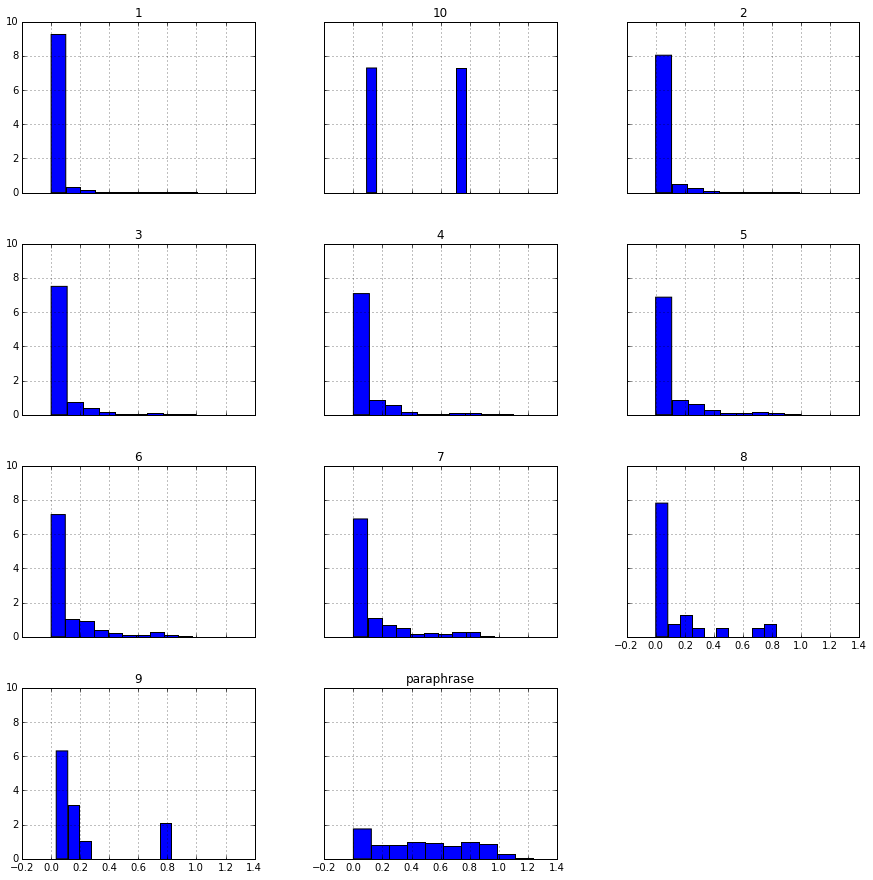

In [11]:
dists.hist(sharex=True, sharey=True, normed=True)